In [25]:
import gymnasium as gym
import numpy as np
import mediapy as media
import torch
import gym_lite6.env, gym_lite6.pickup_task, gym_lite6.utils, gym_lite6.models.mlp
%env MUJOCO_GL=egl # Had to export this before starting jupyter server
# import mujoco
from tqdm import tqdm
import os

env: MUJOCO_GL=egl # Had to export this before starting jupyter server



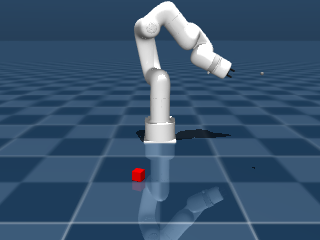

In [9]:
task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=150,
    visualization_width=320,
    visualization_height=240
)

N = 10
observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam"))

In [14]:
def load_model(model_path):
  checkpoint = torch.load(model_path)
  params = checkpoint["params"]

  params["device"] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  policy = gym_lite6.models.mlp.MLPPolicy([64, 64, 64], params).to(params["device"])
  policy.eval()
  policy.load_state_dict(checkpoint["policy_state_dict"])
  return policy, params



# Task Choice
50 trajectories, normalised, lr=1e-3, 10 evals, no dropout, 64 x 64 x 64, 150 steps

## Random init

### Grasp and lift

### Grasp only

In [28]:
# Random init
policy, params = load_model("BC-MLP-MSE/ckpts/lite6_grasp_h64_64_64_2024-09-02_00-11-31/epoch_20.pt")
print(params)

interface = gym_lite6.models.mlp.Interface(params)
qpos0 = None
box_pos0 = None
box_quat0 = None
avg_rewards = []
all_frames = []
for i in tqdm(range(N)):
  avg_reward, frames = interface.evaluate_policy(env, policy, 1, qpos0=qpos0, box_pos0=box_pos0, box_quat0=box_quat0)
  avg_rewards.append(avg_reward)
  all_frames.extend(frames)

print(f"Average rewards: {avg_rewards}, mean: {np.mean(avg_rewards)}")
os.makedirs("results/task_choice", exist_ok=True) 
with media.set_show_save_dir("results/task_choice"):
  #mkdir results/task_choice
  media.show_video(all_frames, title=f"random_init", fps=env.metadata["render_fps"])



Average rewards: [0.0, 0.0, 0.86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], mean: 0.086


## Fixed task

In [31]:
# Diverse data
policy, params = load_model("BC-MLP-MSE/ckpts/lite6_grasp_h64_64_64_2024-09-02_00-11-31/epoch_20.pt")
print(params)

interface = gym_lite6.models.mlp.Interface(params)
qpos0 = np.array([0, 0.541, 1.49 , 2.961, 0.596, 0.203])
box_pos0 = np.array([0.2, 0, 0.0])
box_quat0 = None
avg_rewards = []
all_frames = []
for i in tqdm(range(N)):
  avg_reward, frames = interface.evaluate_policy(env, policy, 1, qpos0=qpos0, box_pos0=box_pos0, box_quat0=box_quat0)
  avg_rewards.append(avg_reward)
  all_frames.extend(frames)

print(f"Average rewards: {avg_rewards}, mean: {np.mean(avg_rewards)}")
os.makedirs("results/task_choice", exist_ok=True) 
with media.set_show_save_dir("results/task_choice"):
  #mkdir results/task_choice
  media.show_video(all_frames, title=f"fixed_task_diverse_data", fps=env.metadata["render_fps"])



{'normalize_qpos': True, 'joint_bounds': {'centre': tensor([0.0000, 0.0000, 2.5875, 0.0000, 0.0000, 0.0000]), 'range': tensor([12.5664,  5.2360,  5.2971, 12.5664,  4.3284, 12.5664])}, 'device': device(type='cuda')}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.48s/it]


Average rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], mean: 0.0


{'normalize_qpos': True, 'joint_bounds': {'centre': tensor([0.0000, 0.0000, 2.5875, 0.0000, 0.0000, 0.0000]), 'range': tensor([12.5664,  5.2360,  5.2971, 12.5664,  4.3284, 12.5664])}, 'device': device(type='cuda')}
Average reward: 0.0


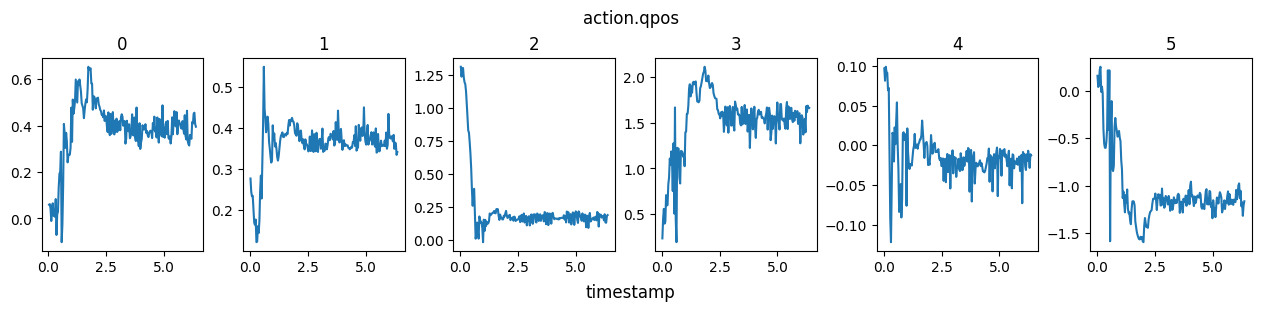

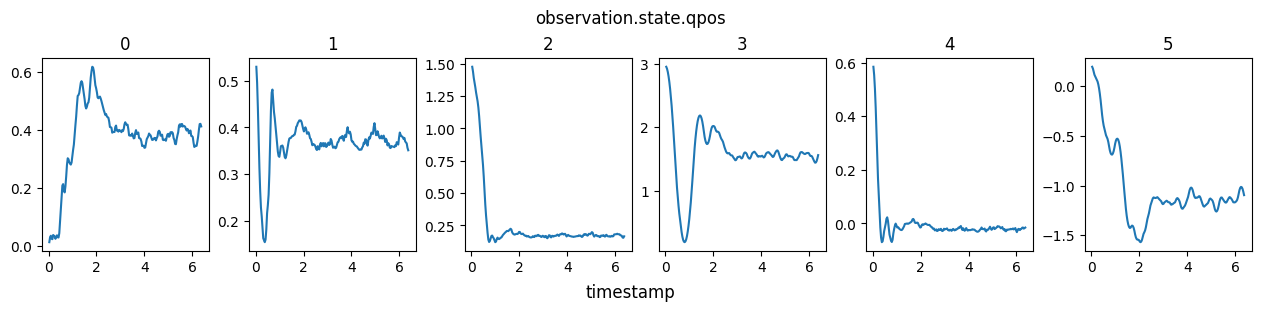

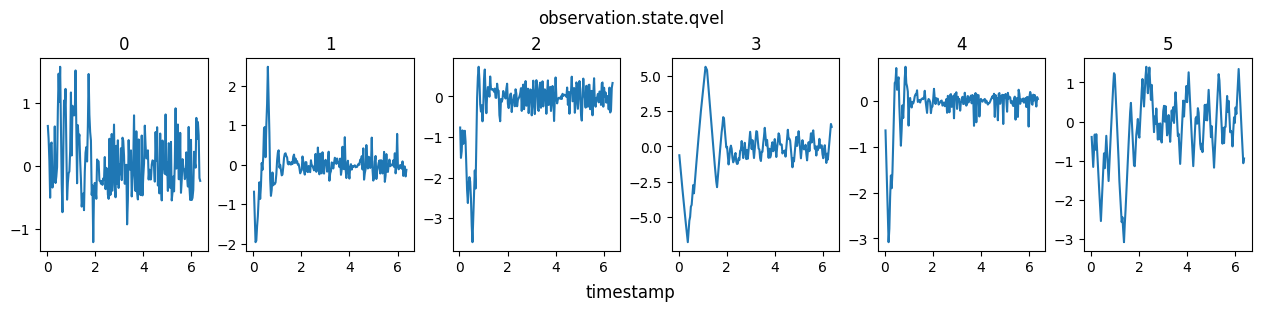

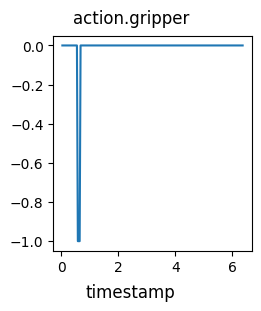

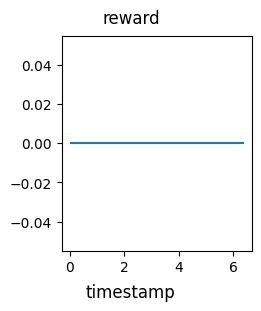

In [27]:
interface = gym_lite6.models.mlp.Interface(params)
avg_reward = 0
observation, info = env.reset(qpos=qpos0, box_pos=box_pos0, box_quat=box_quat0)

# Prepare to collect every rewards and all the frames of the episode,
# from initial state to final state.
rewards = []
frames = []
action = {}

ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

# Render frame of the initial state
frames.append(env.render())

step = 0
done = False
while not done and len(frames) < 200:
  # Prepare observation for the policy running in Pytorch
  # Get qpos in range (-1, 1), gripper is already in range (-1, 1)
  qpos = torch.from_numpy(observation["state"]["qpos"]).unsqueeze(0)
  gripper = interface.embed_gripper(torch.tensor(observation["state"]["gripper"])).unsqueeze(0)
  if interface.params["normalize_qpos"]:
    qpos = interface.normalize_qpos(qpos)
  state = torch.hstack((qpos, gripper))
  image_side = torch.from_numpy(observation["pixels"]["side"]).permute(2, 0, 1).unsqueeze(0) / 255
  image_gripper = torch.from_numpy(observation["pixels"]["gripper"]).permute(2, 0, 1).unsqueeze(0) / 255
  
  # Convert to float32 with image from channel first in [0,255]
  # to channel last in [0,1]
  state = state.to(torch.float32)

  # Send data tensors from CPU to GPU
  state = state.to(interface.params["device"], non_blocking=True)
  image_side = image_side.to(interface.params["device"], non_blocking=True)
  image_gripper = image_gripper.to(interface.params["device"], non_blocking=True)

  # Predict the next action with respect to the current observation
  with torch.inference_mode():
    raw_action = policy.predict(state, image_side, image_gripper).to("cpu")
  
  action["qpos"] = raw_action[:, :6]
  if interface.params["normalize_qpos"]:
    action["qpos"] = interface.unnormalize_qpos(action["qpos"])
  
  action["qpos"] = action["qpos"].flatten().numpy()
  action["gripper"] = interface.decode_gripper(raw_action[:, 6:8]).item()

  # Step through the environment and receive a new observation
  observation, reward, terminated, truncated, info = env.step(action)
  # Keep track of all the rewards and frames
  rewards.append(reward)
  frames.append(env.render())

  ep_dict["action.qpos"].append(action["qpos"])
  ep_dict["action.gripper"].append(action["gripper"])
  ep_dict["observation.state.qpos"].append(observation["state"]["qpos"])
  ep_dict["observation.state.qvel"].append(observation["state"]["qvel"])
  ep_dict["observation.state.gripper"].append(observation["state"]["gripper"])
  ep_dict["observation.pixels.side"].append(observation["pixels"]["side"])
  ep_dict["observation.pixels.gripper"].append(observation["pixels"]["gripper"])
  ep_dict["reward"].append(reward)
  ep_dict["timestamp"].append(env.unwrapped.data.time)
  ep_dict["frame_index"].append(step)

  # The rollout is considered done when the success state is reach (i.e. terminated is True),
  # or the maximum number of iterations is reached (i.e. truncated is True)
  done = terminated | truncated | done
  step += 1

avg_reward = np.mean(rewards)
print(params)
print(f"Average reward: {avg_reward}")
media.show_videos([ep_dict["observation.pixels.side"], ep_dict["observation.pixels.gripper"]], fps=env.metadata["render_fps"])
gym_lite6.utils.plot_dict_of_arrays(ep_dict, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "action.gripper", "reward"], sharey=False)



In [17]:
avg_reward = np.mean(rewards)
